```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate computational performance for
different block sizes for all four numerical schemes, which is required to find
optimal block sizes for performance benchmarking of the schemes.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Performance: Block Size Experiment

This notebook runs a few timesteps of each of the four numerical schemes on a range of different CUDA block sizes.
The efficiency of each simulation run is reported in a text file, which is later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the optimalization results.

### To find your own optimal block sizes
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique filename
test_filename = "blocksize_benchmark_run_0.txt"
file_test = 0
while (os.path.isfile(test_filename)):

    test_filename = "blocksize_benchmark_run_" + str(file_test) + ".txt"
    file_test += 1
    
    
#Use the existing file, do not generate new data
test_filename = "blocksize_benchmark_run_17.txt"
print("Storing data in " + test_filename)

Storing data in blocksize_benchmark_run_17.txt


In [3]:
# Specify python command:
python = "python"
#python = "/home/havahol/miniconda3/envs/gpuocean/bin/python"

In [4]:
def runBenchmark(filename):
    sim = np.array(["FBL", "CTCS", "KP", "CDKLM"])
    #sim = np.array(["CDKLM", "CTCS", "FBL", "KP"])
    #sim = np.array(["FBL"])
    block_width = np.array([4, 8, 12, 16, 24, 32])
    block_height = np.array([4, 8, 12, 16, 24, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                    
                    tic = time.time()
                    
                    test_file.write("=========================================\n")
                    test_file.write(sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j]))
                    test_file.write("-----------------------------------------\n")
                    cmd = [ python, "run_benchmark.py", 
                           "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]),
                           "--simulator", sim[k], #, "--nx", "100", "--ny", "100", 
                           "--steps_per_download", "500"]
                    p = subprocess.Popen(cmd, shell=False, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
                    output = p.stdout.read()
                    test_file.write(str(output) + "\n")
                    test_file.write("=========================================\n")
                    test_file.write("\n")
                    
                    toc = time.time()
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)


if not (os.path.isfile(test_filename)):
    runBenchmark(test_filename)
else:
    print("Using existing run in " + test_filename)

Running with the following:
Widths: [ 4  8 12 16 24 32]
Heights: [ 4  8 12 16 24 32]
FBL [04 x 04] completed in 6.93 s

FBL [04 x 08] completed in 4.33 s

FBL [04 x 12] completed in 3.73 s

FBL [04 x 16] completed in 3.04 s

FBL [04 x 24] completed in 2.54 s

FBL [04 x 32] completed in 2.43 s

FBL [08 x 04] completed in 4.10 s

FBL [08 x 08] completed in 2.86 s

FBL [08 x 12] completed in 2.31 s

FBL [08 x 16] completed in 2.13 s

FBL [08 x 24] completed in 2.22 s

FBL [08 x 32] completed in 2.15 s

FBL [12 x 04] completed in 3.38 s

FBL [12 x 08] completed in 2.25 s

FBL [12 x 12] completed in 2.24 s

FBL [12 x 16] completed in 2.18 s

FBL [12 x 24] completed in 2.13 s

FBL [12 x 32] completed in 2.17 s

FBL [16 x 04] completed in 2.76 s

FBL [16 x 08] completed in 2.06 s

FBL [16 x 12] completed in 2.12 s

FBL [16 x 16] completed in 2.03 s

FBL [16 x 24] completed in 2.11 s

FBL [16 x 32] completed in 2.14 s

FBL [24 x 04] completed in 2.25 s

FBL [24 x 08] completed in 2.12 s

FBL [

In [5]:
def getData(filename):
    # State variables
    simulator = None
    block_width = None
    block_height = None

    data = np.empty((0, 4))

    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)

            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)

            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                data = np.append(data, [[simulator, block_width, block_height, megacells]], axis=0)
                
                block_width = None
                block_height = None

    return data

data = getData(test_filename)
print(data)

[['FBL' '04' '04' '358.65398624']
 ['FBL' '04' '08' '633.69560961']
 ['FBL' '04' '12' '769.83876286']
 ['FBL' '04' '16' '1031.94781166']
 ['FBL' '04' '24' '1354.43948759']
 ['FBL' '04' '32' '1449.93189253']
 ['FBL' '08' '04' '681.25539126']
 ['FBL' '08' '08' '1137.17691734']
 ['FBL' '08' '12' '1620.55127310']
 ['FBL' '08' '16' '1845.04686344']
 ['FBL' '08' '24' '1721.24619220']
 ['FBL' '08' '32' '1837.67943033']
 ['FBL' '12' '04' '881.51469624']
 ['FBL' '12' '08' '1669.69046935']
 ['FBL' '12' '12' '1732.48736391']
 ['FBL' '12' '16' '1789.49834809']
 ['FBL' '12' '24' '1841.62159436']
 ['FBL' '12' '32' '1794.92101946']
 ['FBL' '16' '04' '1189.01085268']
 ['FBL' '16' '08' '1981.59519930']
 ['FBL' '16' '12' '1872.67898036']
 ['FBL' '16' '16' '2005.44744128']
 ['FBL' '16' '24' '1854.12495696']
 ['FBL' '16' '32' '1849.41727408']
 ['FBL' '24' '04' '1649.54559629']
 ['FBL' '24' '08' '1855.54162578']
 ['FBL' '24' '12' '1910.91340786']
 ['FBL' '24' '16' '1858.93170088']
 ['FBL' '24' '24' '1647.7

['04' '08' '12' '16' '24' '32']
CDKLM
         04       08       12       16       24       32
04  121.734  197.836  230.811  269.896  283.885  296.072
08  216.635  323.409  355.332  368.253  372.461  346.358
12  272.207  346.472  376.367  386.478  367.874  365.596
16  323.976  389.756  403.121  358.286  379.294  338.322
24  337.833  395.531  379.647  384.466  350.567  260.901
32  397.982  419.756  431.049  390.847  290.424  336.922
Maximum=431.05
Minimum=121.73
Mean=335.18
[ 7. 10.]
CTCS
         04       08       12       16       24       32
04  370.463  626.371  734.641  967.975  1072.23  1080.35
08  689.533  1151.11  1355.09  1359.74  1237.67  1303.53
12  924.672  1438.54  1347.94  1309.72  1272.28  1218.99
16   1265.4  1535.79  1411.56  1493.11  1284.45  1105.57
24  1484.84  1426.16  1393.89  1339.16   1212.8  845.334
32  1688.09  1621.61  1461.66  1296.79  950.494   1086.8
Maximum=1688.09
Minimum=370.46
Mean=1204.57
[ 7. 10.]
FBL
         04       08       12       16       24  

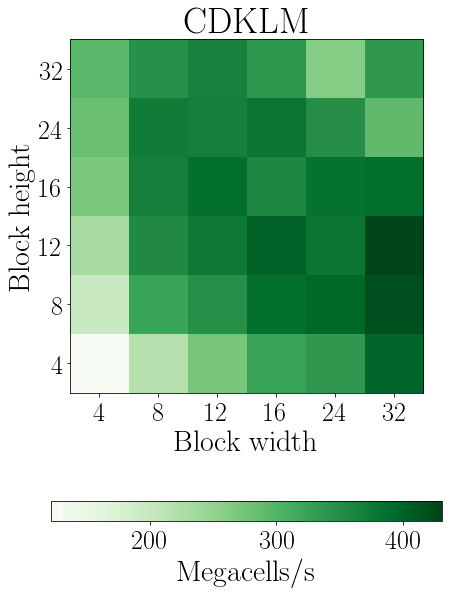

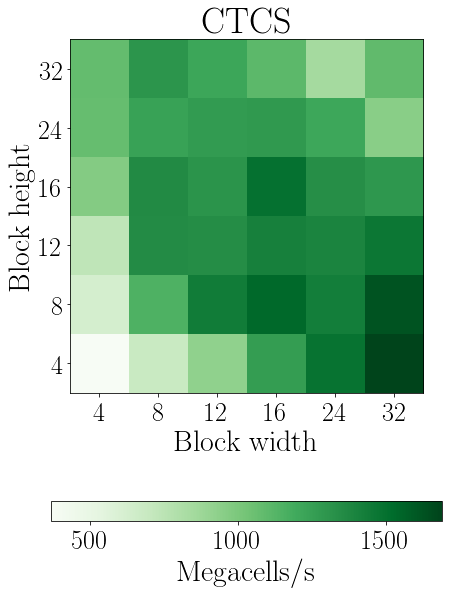

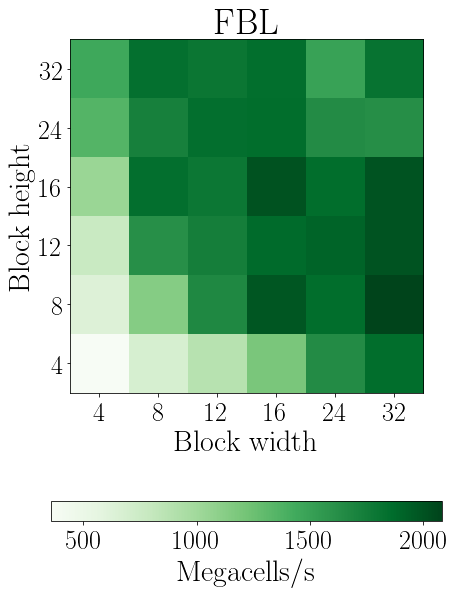

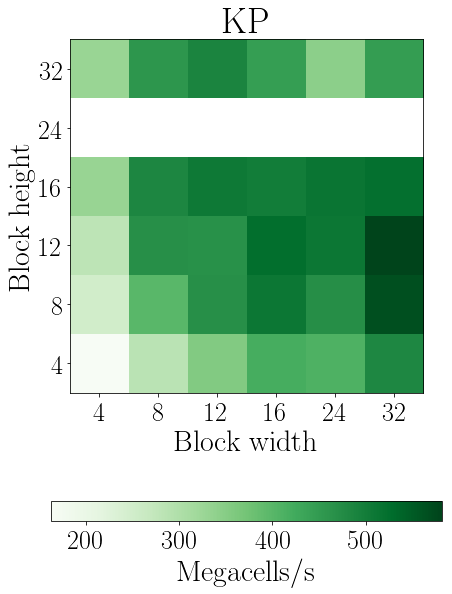

In [6]:
simulators = np.unique(data[:,0])
block_widths = np.unique(data[:,1])
block_heights = np.unique(data[:,2])

print(block_widths)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for simulator in simulators:
    print(simulator)
    
    df = pd.DataFrame(index=block_widths, columns=block_heights)

    # Pick this simulator data only and sort into a dataframe
    columns = data[:,0] == simulator
    for record in data[columns]:
        block_width = record[1]
        block_height = record[2]
        megacells = np.float32(record[3])
        df[block_height][block_width] = megacells
        
    maximum = np.nanmax(df.values)
    minimum = np.nanmin(df.values)
    mean = np.nanmean(df.values)
    print(df)
    print("Maximum={:.2f}".format(maximum))
    print("Minimum={:.2f}".format(minimum))
    print("Mean={:.2f}".format(mean))

    # Plot dataframe
    x = df.index.values.astype(np.int)
    y = df.columns.values.astype(np.int)
    z = np.transpose(df.values.astype(np.float32))
    
    fontsize=30
    fig = plt.figure(figsize=(7,10))
    ax = fig.add_subplot(111)
    img = ax.imshow(z, origin='lower', cmap=cm.Greens, interpolation="None")
    
    plt.xticks( range(len(x)), x, fontsize=fontsize-4)
    ax.set_xlabel('Block width', fontsize=fontsize)
    plt.yticks( range(len(y)), y, fontsize=fontsize-4)
    ax.set_ylabel('Block height', fontsize=fontsize)

    cb = plt.colorbar(img, orientation="horizontal", pad=0.2)
    cb.ax.tick_params(labelsize=fontsize-4)
    #cb.ax.set_ylabel('Megacells/s')#, rotation=270)
    cb.set_label('Megacells/s', fontsize=fontsize)#, labelpad=-40, y=0.45)



    
    #plt.title(simulator + " [megacells/s]", fontsize=fontsize+6)
    plt.title(simulator, fontsize=fontsize+6)
    fig.savefig(test_filename.replace('.txt', '_'+simulator+'.pdf'))
    print(fig.get_size_inches())

In [7]:
print(test_filename.replace('.txt', '_cdklm.pdf'))

blocksize_benchmark_run_17_cdklm.pdf
